<a href="https://colab.research.google.com/github/ambideXtrous9/UNet-on-Brain-MRI-Images/blob/main/U-Net-Brain-MRI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.3 MB/s eta 0:00:00


In [2]:
import os
import random
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import cv2
from google.colab.patches import cv2_imshow

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/MTP CODE/RegGan_Data.zip' -r '/content/'

In [6]:
fname = '/content/RegGan_Data.zip'
!unzip -q $fname -d /content/

In [7]:
folder_path = '/content/RegGan_Data'

In [8]:
trainA_folder = os.path.join(folder_path, "trainA")
trainA_files = os.listdir(trainA_folder)
trainA_paths = [os.path.join(trainA_folder, file) for file in trainA_files]
print(len(trainA_paths))

# Get list of all image filenames in trainB folder
trainB_folder = os.path.join(folder_path, "trainB")
trainB_files = os.listdir(trainB_folder)
trainB_paths = [os.path.join(trainB_folder, file) for file in trainB_files]
print(len(trainB_paths))

# Combine trainA and trainB paths into a DataFrame
df = pd.DataFrame({"trainA": trainA_paths, "trainB": trainB_paths})

5760
5760


In [9]:
df.head()

,trainA,trainB
0,/content/RegGan_Data/trainA/05024.jpeg,/content/RegGan_Data/trainB/05024.jpeg
1,/content/RegGan_Data/trainA/00381.jpeg,/content/RegGan_Data/trainB/00381.jpeg
2,/content/RegGan_Data/trainA/02945.jpeg,/content/RegGan_Data/trainB/02945.jpeg
3,/content/RegGan_Data/trainA/03805.jpeg,/content/RegGan_Data/trainB/03805.jpeg
4,/content/RegGan_Data/trainA/00724.jpeg,/content/RegGan_Data/trainB/00724.jpeg


In [10]:
trainA_folder = os.path.join(folder_path, "testA")
trainA_files = os.listdir(trainA_folder)
trainA_paths = [os.path.join(trainA_folder, file) for file in trainA_files]
print(len(trainA_paths))

# Get list of all image filenames in trainB folder
trainB_folder = os.path.join(folder_path, "testB")
trainB_files = os.listdir(trainB_folder)
trainB_paths = [os.path.join(trainB_folder, file) for file in trainB_files]
print(len(trainB_paths))

# Combine trainA and trainB paths into a DataFrame
test_df = pd.DataFrame({"trainA": trainA_paths, "trainB": trainB_paths})

767
767


In [11]:
def show_sample(idx=0):
  image1 = cv2.imread(trainA_paths[idx])
  image1 = cv2.resize(image1, (224, 224))  
  image2 = cv2.imread(trainB_paths[idx])
  image2 = cv2.resize(image2, (224, 224))
  result = cv2.hconcat([image1, image2])
  cv2_imshow(result)
  

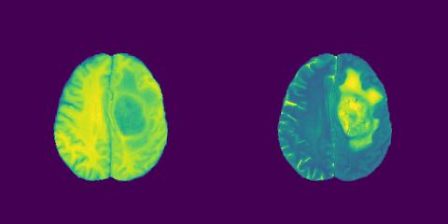

In [12]:
show_sample(10)

In [13]:
def has_three_channels(image_path):
    with Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
df = df[df['trainA'].apply(has_three_channels)]
df = df[df['trainB'].apply(has_three_channels)]
     

In [14]:
# Filter the DataFrame to keep only the images with 3 channels
test_df = test_df[test_df['trainA'].apply(has_three_channels)]
test_df = test_df[test_df['trainB'].apply(has_three_channels)]
     

In [15]:
train_df, val_df = train_test_split(df,test_size=0.1)

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

In [17]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

In [18]:
class UNetDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        imgA = row['trainA']
        imgB = row['trainB']
        
        # load the image and apply transform
        imgA = PIL.Image.open(imgA)
        imgA = self.transform(imgA)

        imgB = PIL.Image.open(imgB)
        imgB = self.transform(imgB)
                
        return dict(
        imgA = imgA,
        imgB = imgB)

In [19]:
class UNetDataModule(pl.LightningDataModule):
  def __init__(self,train_df : pd.DataFrame,val_df : pd.DataFrame,test_df : pd.DataFrame,
               train_transform : train_transform,val_transform : val_transform,batch_size : int = 8):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.train_transform = train_transform
    self.val_transform = val_transform


  def setup(self,stage=None):
    self.train_dataset = UNetDataset(self.train_df,self.train_transform)
    self.val_dataset = UNetDataset(self.val_df,self.val_transform)
    self.test_dataset = UNetDataset(self.test_df,self.val_transform)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=4)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=4)


In [20]:
BATCH_SIZE = 32
N_EPOCHS = 10

data_module = UNetDataModule(train_df,val_df,test_df,train_transform,
                            val_transform,batch_size = BATCH_SIZE)
data_module.setup()

In [21]:
class UNetModel(pl.LightningModule):
  def __init__(self,in_channels=3, out_channels=3):
    super().__init__()

    self.criterion = nn.MSELoss()

    # Encoder layers
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Decoder layers
    self.upconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
    self.upconv7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.upconv8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.upconv9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

    # Output layer
    self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

  def forward(self, x):
    # Encoder
    x1 = nn.functional.relu(self.conv1(x))
    x2 = nn.functional.relu(self.conv2(self.pool(x1)))
    x3 = nn.functional.relu(self.conv3(self.pool(x2)))
    x4 = nn.functional.relu(self.conv4(self.pool(x3)))
    x5 = nn.functional.relu(self.conv5(self.pool(x4)))

    # Decoder
    x6 = nn.functional.relu(self.upconv6(x5))
    x6 = torch.cat([x6, x4], dim=1)
    x6 = nn.functional.relu(self.conv6(x6))
    x7 = nn.functional.relu(self.upconv7(x6))
    x7 = torch.cat([x7, x3], dim=1)
    x7 = nn.functional.relu(self.conv7(x7))
    x8 = nn.functional.relu(self.upconv8(x7))
    x8 = torch.cat([x8, x2], dim=1)
    x8 = nn.functional.relu(self.conv8(x8))
    x9 = nn.functional.relu(self.upconv9(x8))
    x9 = torch.cat([x9, x1], dim=1)
    x9 = nn.functional.relu(self.conv9(x9))

    # Output layer
    x10 = self.conv10(x9)
    return x10

  def training_step(self,batch,batch_idx):
    imgA = batch['imgA']
    imgB = batch['imgB']
    fakeB = self(imgA)
    loss = self.criterion(fakeB, imgB)
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def validation_step(self,batch,batch_idx):
    imgA = batch['imgA']
    imgB = batch['imgB']
    fakeB = self(imgA)
    loss = self.criterion(fakeB, imgB)
    self.log("val_loss",loss,prog_bar=True,logger=True)
    return loss
  
  def test_step(self,batch,batch_idx):
    imgA = batch['imgA']
    imgB = batch['imgB']
    fakeB = self(imgA)
    loss = self.criterion(fakeB, imgB)
    self.log("test_loss",loss,prog_bar=True,logger=True)
    return loss

  def configure_optimizers(self):
    return optim.Adam(self.parameters(),lr = 0.0001)

In [22]:
model = UNetModel()

In [23]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min')

In [24]:
trainer = pl.Trainer(devices=1, accelerator="gpu",
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type            | Params
-----------------------------------------------
0  | criterion | MSELoss         | 0     
1  | conv1     | Conv2d          | 1.8 K 
2  | conv2     | Conv2d          | 73.9 K
3  | conv3     | Conv2d          | 295 K 
4  | conv4     | Conv2d          | 1.2 M 
5  | conv5     | Conv2d          | 4.7 M 
6  | pool      | MaxPool2d       | 0     
7  | upconv6   | ConvTranspose2d | 2.1 M 
8  | conv6     | Conv2d          | 4.7 M 
9  | upconv7   | ConvTranspose2d | 524 K 
10 | conv7     | Conv2d          | 1.2 M 
11 | upconv8   | ConvTranspose2d | 131 K 
12 | conv8     | Conv2d          | 295 K 
13 | upconv9   | ConvTranspose2d | 32.8 K
14 | conv9     | Conv2d          | 73.8 K
15 | conv10    | Conv2d          | 195   
-----------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
1

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 162: 'val_loss' reached 0.00387 (best 0.00387), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 324: 'val_loss' reached 0.00286 (best 0.00286), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 486: 'val_loss' reached 0.00263 (best 0.00263), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 648: 'val_loss' reached 0.00244 (best 0.00244), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 810: 'val_loss' reached 0.00227 (best 0.00227), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 972: 'val_loss' reached 0.00212 (best 0.00212), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1134: 'val_loss' reached 0.00193 (best 0.00193), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1296: 'val_loss' reached 0.00191 (best 0.00191), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 1458: 'val_loss' reached 0.00160 (best 0.00160), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1620: 'val_loss' reached 0.00144 (best 0.00144), saving model to '/content/checkpoints/best_cp.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# **Test**

In [26]:
model_path = '/content/checkpoints/best_cp.ckpt'

In [27]:
trained_model = UNetModel.load_from_checkpoint(model_path)
trained_model.freeze()
trainer.test(trained_model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0019568174611777067   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0019568174611777067}]

In [28]:
def img_check(img):
  # Check number of channels
  if img.shape[2] == 3 and img[:,:,0].mean() != img[:,:,1].mean():
      print('Image is RGB')
  elif img.shape[2] == 3 and img[:,:,0].mean() == img[:,:,1].mean():
      print('Image is BGR')
  else:
      print('Image has a different number of channels')


In [41]:
import matplotlib.pyplot as plt
def predict_single_image(model, idx=0):
    model.eval()
    img_path = test_df.iloc[idx]['trainA']
    
    imgB = test_df.iloc[idx]['trainB']
    imgB = cv2.imread(imgB)
    imgB = cv2.resize(imgB, (224, 224))

    img = cv2.imread(img_path)
    input = cv2.resize(img, (224, 224))

    image = PIL.Image.open(img_path)
    image = val_transform(image)

    # add batch dimension
    image = image.unsqueeze(0)

    # pass the image through the model
    with torch.no_grad():
        output = model(image)

    # remove the batch dimension and convert output to a PIL image
    output = output.squeeze(0)
    output = transforms.ToPILImage()(output)
    output = np.array(output)
    # Denormalize the image by multiplying it with 255
    output = output * 255
    # Clip the image pixel values to [0, 255]
    output = np.clip(output, 0, 255)
    # Convert the image to uint8 datatype
    output = output.astype(np.uint8)
    img = []
    img.append(input)
    img.append(output)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    for j in range(2):
        # Display the image
        axs[j].imshow(img[j])
        axs[j].axis('off')

    plt.show()
    

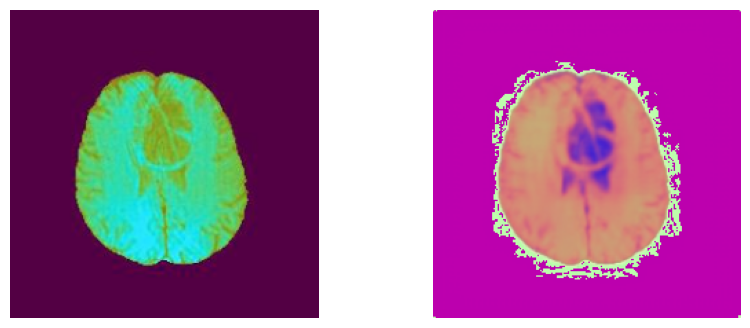

In [42]:
predict_single_image(trained_model,5)